In [74]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname((os.path.abspath(os.getcwd()))))

from utils import fft_denoise, wavelet_denoise, compute_metrics
from datasets import ECGDataset
from models import *

model_dict = {
	"U-Net": UNet,
    "ACDAE": ACDAE,
    "DACNN": DACNN,
    "DANCER": DANCER,
}


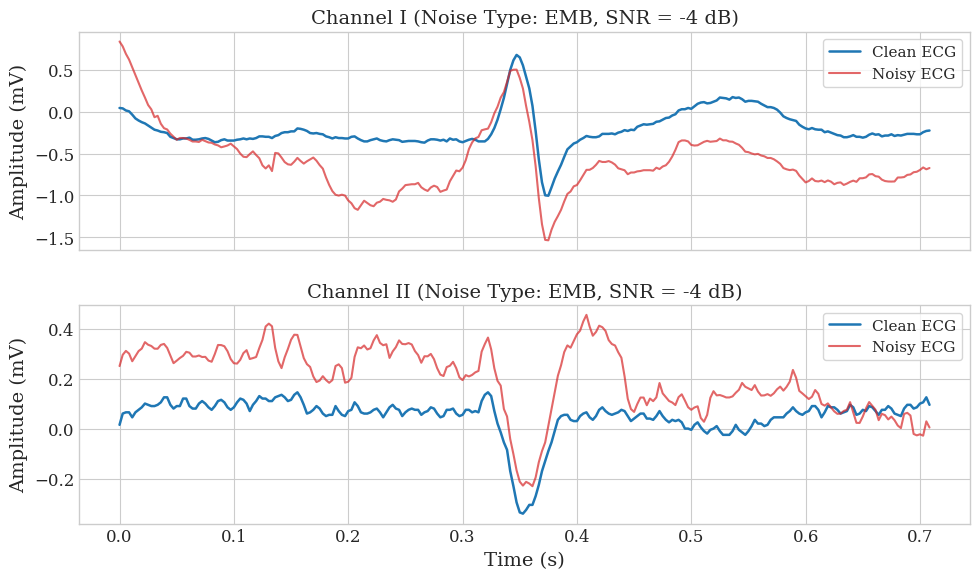

In [96]:
noise_type = "emb"
snr_db = -4

dataset = ECGDataset(
    split="test",
    noise_type=noise_type,
    snr_db=snr_db,
    split_dir="./data_split",
)

idx = np.random.randint(0, len(dataset) - 1)
noisy, clean = dataset[idx]

mean, std = dataset.get_stats()
mean = mean.squeeze(0).permute(1, 0)
std = std.squeeze(0).permute(1, 0)
ori_noisy = noisy * std + mean

# --------------------------
# 绘图配置
# --------------------------
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "lines.linewidth": 1.5,
})

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

time = np.arange(clean.shape[-1]) / 360  # 假设采样率 250 Hz，可改成你的采样率

# 通道 1
axes[0].plot(time, clean[0].numpy(), color="#1f77b4", label="Clean ECG", linewidth=1.8)
axes[0].plot(time, ori_noisy[0].numpy(), color="#d62728", label="Noisy ECG", alpha=0.7)
axes[0].set_ylabel("Amplitude (mV)")
axes[0].set_title(f"Channel I (Noise Type: {noise_type.upper()}, SNR = {snr_db} dB)")
axes[0].legend(loc="upper right", frameon=True)

# 通道 2
axes[1].plot(time, clean[1].numpy(), color="#1f77b4", label="Clean ECG", linewidth=1.8)
axes[1].plot(time, ori_noisy[1].numpy(), color="#d62728", label="Noisy ECG", alpha=0.7)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude (mV)")
axes[1].set_title(f"Channel II (Noise Type: {noise_type.upper()}, SNR = {snr_db} dB)")
axes[1].legend(loc="upper right", frameon=True)

plt.tight_layout(pad=1.2)
plt.subplots_adjust(hspace=0.25)

# 可选：保存论文图
plt.savefig("ecg_noisy_vs_clean.png", dpi=400, bbox_inches="tight")
plt.show()


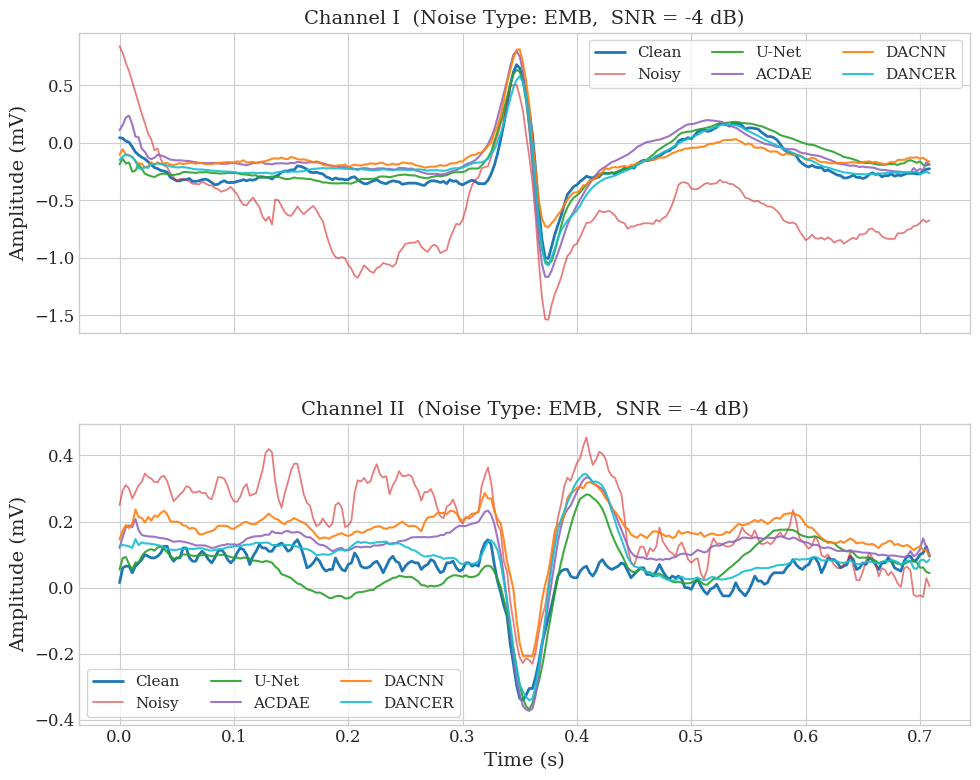

In [98]:
# model_name = "U-Net"  # Change this to test different models

denoised_output_dict = {}
for model_name in model_dict.keys():
	model = model_dict[model_name]()
	model.load_state_dict(torch.load(f"./checkpoints/best_{model_name}_{noise_type}_snr_{snr_db}.pth", map_location="cpu"))
	model.eval()

	with torch.no_grad():
		noisy_input = torch.tensor(noisy)
		noisy_input = noisy_input.unsqueeze(0)  # Add batch dimension
		denoised_output = model(noisy_input)

	denoised_output = denoised_output.squeeze(0)  # Remove batch dimension

	denoised_output = denoised_output * std + mean
	
	denoised_output_dict[model_name] = denoised_output


time = np.arange(clean.shape[-1]) / 360  # 假设采样率250Hz
colors = {
    "Clean": "#1f77b4",
    "Noisy": "#d62728",
}
model_colors = [
    "#2ca02c", "#9467bd", "#ff7f0e", "#17becf", "#8c564b", "#e377c2"
]  # 不同模型配色

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# -------- 通道 1 --------
axes[0].plot(time, clean[0].numpy(), label="Clean", color=colors["Clean"], linewidth=2.0)
axes[0].plot(time, ori_noisy[0].numpy(), label="Noisy", color=colors["Noisy"], alpha=0.6, linewidth=1.3)

for i, (model_name, denoised_output) in enumerate(denoised_output_dict.items()):
    axes[0].plot(time, denoised_output[0].numpy(), label=model_name, color=model_colors[i % len(model_colors)], alpha=0.9)

axes[0].set_ylabel("Amplitude (mV)")
axes[0].set_title(f"Channel I  (Noise Type: {noise_type.upper()},  SNR = {snr_db} dB)")
axes[0].legend(ncol=3, frameon=True)

# -------- 通道 2 --------
axes[1].plot(time, clean[1].numpy(), label="Clean", color=colors["Clean"], linewidth=2.0)
axes[1].plot(time, ori_noisy[1].numpy(), label="Noisy", color=colors["Noisy"], alpha=0.6, linewidth=1.3)

for i, (model_name, denoised_output) in enumerate(denoised_output_dict.items()):
    axes[1].plot(time, denoised_output[1].numpy(), label=model_name, color=model_colors[i % len(model_colors)], alpha=0.9)

axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude (mV)")
axes[1].set_title(f"Channel II  (Noise Type: {noise_type.upper()},  SNR = {snr_db} dB)")
axes[1].legend(ncol=3, frameon=True)

plt.tight_layout(pad=1.2)
plt.subplots_adjust(hspace=0.3)

# --------------------------
# 保存高分辨率图
# --------------------------
plt.savefig(f"ecg_denoising_comparison.png", dpi=400, bbox_inches="tight")
plt.show()